# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import frnn

sys.path.append('../..')

from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
import copy
from LightningModules.Embedding.utils import build_edges, graph_intersection

device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In [3]:
with open("example_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [4]:
model = LayerlessEmbedding(hparams)

## The Dataset

To load the data, we call a `setup` method. There is some flexibility in how to handle data, and one should check the Pytorch Lightning docs to see the spectrum of options. This is my favourite way: Hide all of the data loading inside the Lightning module. We are explicitly calling `setup` here because we're going to visualise some of the data first. In future, once you know the nature of the data, we can skip this step, since the trainer will call this automatically when it starts training. 

NOTE: This may take a minute or two, since the data is being trimmed to particles above a certain momentum threshold.

In [5]:
%%time
model.setup(stage="fit")

CPU times: user 94.3 ms, sys: 57.7 ms, total: 152 ms
Wall time: 2.83 s


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [6]:
trainset = model.trainset

In [7]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [8]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

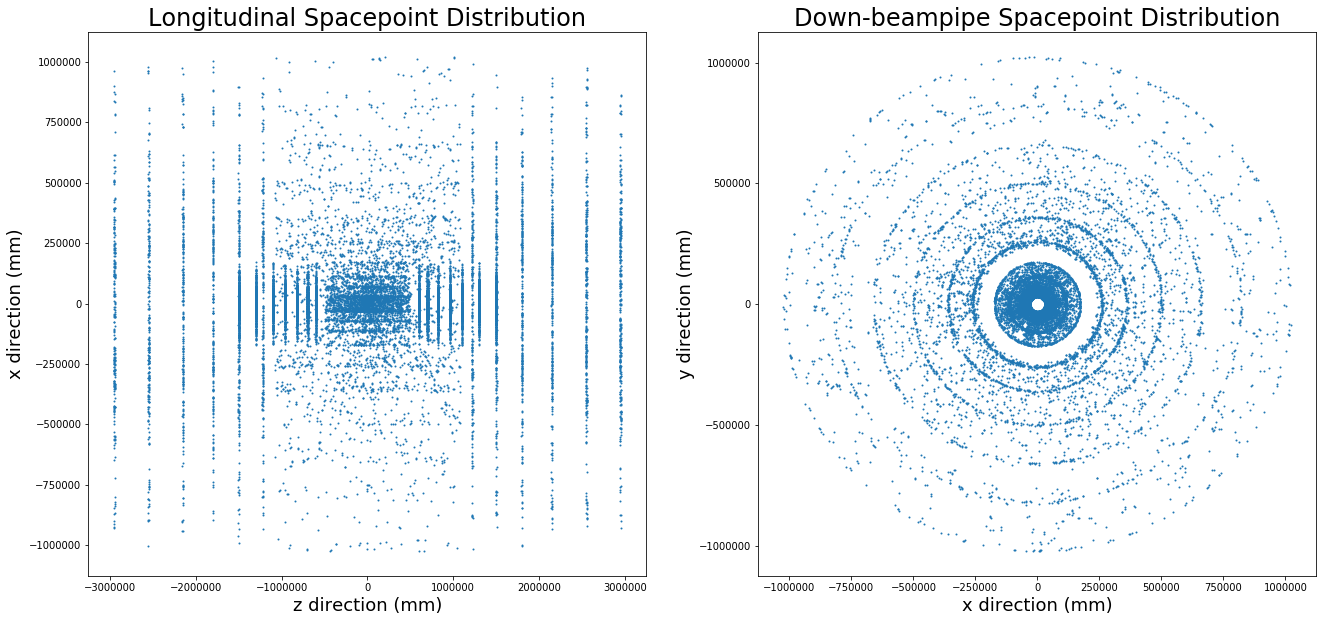

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [19]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

In [20]:
particle_num, particle_counts

(array([  4503599694479360,   4503599711256576,   4503599761588224, ...,
        153150976377749504, 153150976394526720, 153157573682462721]),
 array([10,  4,  8, ...,  8,  8,  1]))

Number of particles: 1720


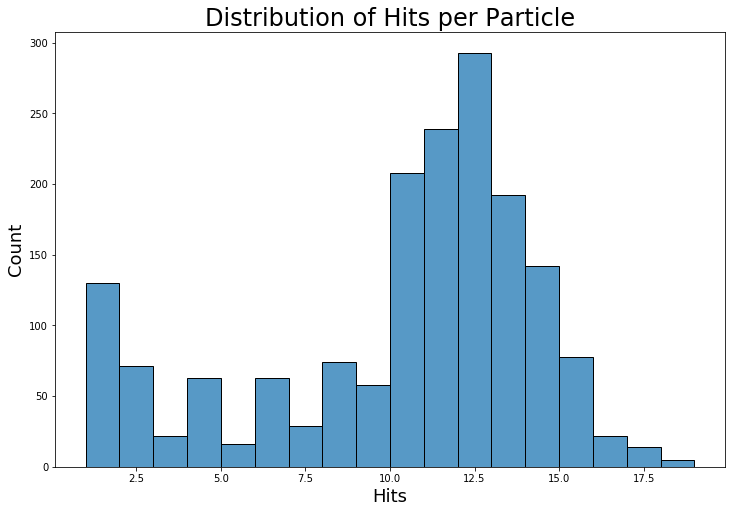

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[1:], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)
print("Number of particles:", len(particle_num))

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='eff',
    mode="max",
    save_top_k=2,
    save_last=True)

In [8]:
logger = WandbLogger(project=hparams["project"], group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=logger, num_sanity_val_steps=0, callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)


Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | layers    | ModuleList | 5.3 M 
1 | emb_layer | Linear     | 8.2 K 
2 | norm      | LayerNorm  | 2.0 K 
3 | act       | Tanh       | 0     
-----------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.049    Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/dat

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

../../LightningModules/Embedding/embedding_base.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
../../LightningModules/Embedding/embedding_base.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
model = model.to(device)

In [38]:
results = model.shared_evaluation(model.valset[0].to(device), 0, 1.6, 1000)

In [39]:
results["truth"].sum() / results["truth_graph"].shape[1], results["truth"].sum() / results["preds"].shape[1]

(tensor(0.9908), tensor(0.0082))

## Performance

### Load best model

In [13]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints/LRT_mu40_0GeV_Embedding/um7sz5ip/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

In [14]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [15]:
model.hparams["train_split"] = [10, 10, 10]

In [16]:
%%time
model.setup(stage="fit")

CPU times: user 25.5 ms, sys: 27.5 ms, total: 53 ms
Wall time: 668 ms


In [18]:
for batch in model.val_dataloader():
    
    print(batch)
    
    results = model.shared_evaluation(batch.to(device), 0, 1.5, 1000)
    print("Eff:", results["truth"].sum() / results["truth_graph"].shape[1],
         "Pur:", results["truth"].sum() / results["truth"].shape[0])
    
    break

Batch(batch=[20482], event_file=[1], hid=[20482], layerless_true_edges=[2, 18413], layers=[20482], pid=[20482], ptr=[2], signal_true_edges=[2, 18413], x=[20482, 3])
Eff: tensor(0.9827) Pur: tensor(0.0096)
